<a href="https://colab.research.google.com/github/bgohrani/Convolutional_Neural_Networks/blob/main/3.SqueezeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error
import matplotlib.colors
import math
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import time
sns.set()
import torchvision.models as models
import copy
import torchvision
from torchvision.transforms import transforms

#importing essential libraries

In [ ]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',	'truck']		

#Writing down the classes on the CIFAR-10 dataset

In [ ]:
def evaluation(dataloader, network):
  accuracy_count = 0
  total = 0
  for data in dataloader:
    input,labels = data
    input, labels = input.to(device), labels.to(device)
    output = network(input)
    total += labels.size(0)
    max_values1,max_classes1 = torch.max(output, axis=1)
    accuracy_count += (labels == max_classes1).sum().item()

  computed_accuracy = (accuracy_count/total)*100
  return computed_accuracy

#Here is our evaluation function
#We pass it any data (train/test loader and the network)
#It iterates over that, takes each batch with its inputs and labels
#Inputs are passed to the network, output is generated and compared to labels and accuracy count is maintained
#Total accuaracy_count is divided by total no of labels to give the answer in percentage
#Care is taken to move inputs and labels to device

In [ ]:
device = torch.device('cuda')

#Enabling GPU support

In [ ]:
def visualize_batch(dataloader,network,classes, predicted=True):
  dataiter = iter(dataloader)
  images,labels = dataiter.next()
  images,labels = images.to(device), labels.to(device)
  images = images/2 + 0.5
  if predicted == True:
    output = network(images)
    _,pred_classes = torch.max(output, axis=1)
  grid = torchvision.utils.make_grid(images)

  plt.imshow(np.transpose(grid.cpu().numpy(),(1,2,0)))
  plt.show()
  if predicted == True:
    print (" ".join([classes[pred_classes[j]] for j in range(16)]))
  else:
    print (" ".join([classes[labels[j]] for j in range(16)]))

#We want to use the network we have to predict on the test data, so we'll write function which returns the names of the objects
#We take a single batch of 16 images, pass them through the network at once, and also put them in a grid to visualize.
#We display the grid and if predicted is passed as true then print out the classes as given by the network
#If predicted is given as false, we will print out the ground truths or the true values as given in the data


In [ ]:
train_transform = torchvision.transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = torchvision.transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#Code for applying required transformations to our images

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True,transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True,transform=test_transform)

#Loading CIFAR-10 data and applying transformations


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=16,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=16,shuffle=True)

#Creating dataloaders to load images in batches and shuffle

**SqueezeNet** is a commonly used Deep Neural Network which finds applications in computer vision. It was developed jointly by DeepScale, UC Berkely and Stanford. The goal with Squeezenet was to build a smaller network which consumes less memory and can be easily transmitted. The predominant feature of this network is that it consists of _Fire Modules_, which help in squeezing parameters by applying 1x1 size kernels to integrate data over several channels and then expand it again by applying 1x1 filters to give out many channels. The network contains 18 layers with ~5M parameters.

In [ ]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)

#Downloading pre-trained squeezenet model

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


In [ ]:
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
for param in squeezenet.parameters():
  param.requires_grad = False

input_features = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(input_features,10,kernel_size=(1,1),stride=(1,1))

#Modifying the last layer as usual to predict over 10 classes
#This is the only layer we will be training

In [ ]:
for param in squeezenet.parameters():
  if param.requires_grad == True:
    print(param.shape)

torch.Size([10, 512, 1, 1])
torch.Size([10])


In [ ]:
squeezenet = squeezenet.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(squeezenet.parameters(),lr = 0.00001)

#Moving our network to GPU, setting criterion and optimizer as usual

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


min loss is: 2.671009063720703
min loss is: 2.2163150310516357
min loss is: 2.1542611122131348
1.0   tensor(2.7720, device='cuda:0', grad_fn=<NllLossBackward>)
min loss is: 1.964012622833252
min loss is: 1.858239769935608
2.0   tensor(2.1628, device='cuda:0', grad_fn=<NllLossBackward>)
3.0   tensor(2.7062, device='cuda:0', grad_fn=<NllLossBackward>)
4.0   tensor(2.3695, device='cuda:0', grad_fn=<NllLossBackward>)
5.0   tensor(2.1735, device='cuda:0', grad_fn=<NllLossBackward>)
6.0   tensor(1.9735, device='cuda:0', grad_fn=<NllLossBackward>)
7.0   tensor(2.3523, device='cuda:0', grad_fn=<NllLossBackward>)
8.0   tensor(1.9998, device='cuda:0', grad_fn=<NllLossBackward>)
9.0   tensor(2.3764, device='cuda:0', grad_fn=<NllLossBackward>)
10.0   tensor(2.4409, device='cuda:0', grad_fn=<NllLossBackward>)
11.0   tensor(1.8833, device='cuda:0', grad_fn=<NllLossBackward>)
12.0   tensor(2.1256, device='cuda:0', grad_fn=<NllLossBackward>)
min loss is: 1.8412543535232544
13.0   tensor(2.2361, device

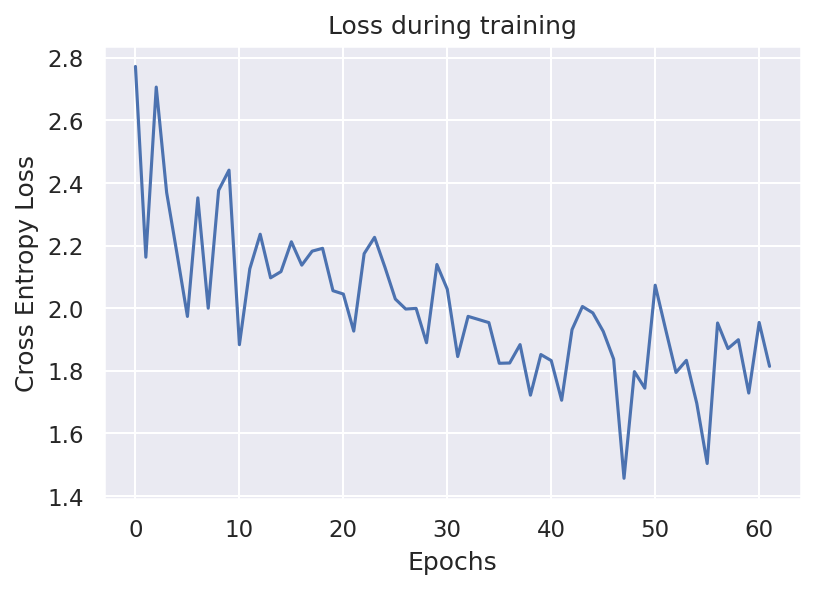

In [ ]:
epochs = 2
loss = []
min_loss = 1000
for j in tqdm_notebook(range(epochs)): 
  k = 0
  for i, data in enumerate(trainloader,0):
    k += 1
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    output = squeezenet(inputs)
    loss_train = loss_func(output,labels)
    loss_train.backward()
    opt.step()

    if min_loss > loss_train.item():
      min_loss = loss_train.item()
      print('min loss is:', min_loss)
      best_model = copy.deepcopy(squeezenet.state_dict())

    del inputs, labels, output
    torch.cuda.empty_cache()
    if k%100 == 0:
      print(k/100,' ',loss_train)
      loss.append(loss_train.item())   

    


plt.figure(dpi =150)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss during training')
plt.show()

#Training loop same as earlier 

In [ ]:
training_loss = evaluation(trainloader, squeezenet)
test_loss = evaluation(testloader, squeezenet)

print('Training accuracy is: ', training_loss)
print('Test accuracy is: ', test_loss)

Training accuracy is:  39.922000000000004
Test accuracy is:  39.58
